:warning:**IMPORTANT NOTICE**:warning:\
*Since the initial parameterisation and gradient descent optimisation are stochastic processes, the training of a neural network is not fully reproducible.*

*Therefore, it is not recommended to re-run this script as it will overwrite the original calibration of the neural network used in the work presented here.
The purpose of this script is solely to document the training procedure and can be copied as a template to fit other new neural networks.*

*To experiment with the models calibrated here, they can be loaded from the `saved_models` directory.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Normalization
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, schedules
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.callbacks import CSVLogger, EarlyStopping

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_temperature_only
from ml_tb.plot import plot_multiple_training_curves

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_3236\802759208.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load validation datasets

In [2]:
# Load the data
val_data_dir = Path("kfold_datasets")

DATA_train_0 = np.loadtxt(Path(val_data_dir, "train_data_0.csv"), delimiter=",")
DATA_val_0 = np.loadtxt(Path(val_data_dir, "test_data_0.csv"), delimiter=",")

DATA_train_1 = np.loadtxt(Path(val_data_dir, "train_data_1.csv"), delimiter=",")
DATA_val_1 = np.loadtxt(Path(val_data_dir, "test_data_1.csv"), delimiter=",")

DATA_train_2 = np.loadtxt(Path(val_data_dir, "train_data_2.csv"), delimiter=",")
DATA_val_2 = np.loadtxt(Path(val_data_dir, "test_data_2.csv"), delimiter=",")

DATA_train_3 = np.loadtxt(Path(val_data_dir, "train_data_3.csv"), delimiter=",")
DATA_val_3 = np.loadtxt(Path(val_data_dir, "test_data_3.csv"), delimiter=",")

DATA_train_4 = np.loadtxt(Path(val_data_dir, "train_data_4.csv"), delimiter=",")
DATA_val_4 = np.loadtxt(Path(val_data_dir, "test_data_4.csv"), delimiter=",")

train_data_list = [DATA_train_0, DATA_train_1, DATA_train_2, DATA_train_3, DATA_train_4]
val_data_list = [DATA_val_0, DATA_val_1, DATA_val_2, DATA_val_3, DATA_val_4]


## Set-up global training parameters

Define a function to calculate RMSE for pressure and temperature for unscaled values to have an interpretable metric.

In [3]:
scaling_pt = MinMaxScaler(min=400, max=900, axis=0)
inv_scaling_pt = MinMaxScaler(min=400, max=900, axis=0, invert=True)

def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_temperature_only(y_true, y_pred, inv_scaling_pt)

In [4]:
CALLBACKS_0 = [CSVLogger("AA_k_TiXMg_0.log"), EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)]
CALLBACKS_1 = [CSVLogger("AA_k_TiXMg_1.log"), EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)]
CALLBACKS_2 = [CSVLogger("AA_k_TiXMg_2.log"), EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)]
CALLBACKS_3 = [CSVLogger("AA_k_TiXMg_3.log"), EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)]
CALLBACKS_4 = [CSVLogger("AA_k_TiXMg_4.log"), EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)]

callsbacks_list = [CALLBACKS_0, CALLBACKS_1, CALLBACKS_2, CALLBACKS_3, CALLBACKS_4]

In [5]:
# train loop

def train_model(DATA_train, DATA_val, CALLBACKS, model_name):
    # split up data
    data_train = DATA_train[:, [1, 6]]
    data_val = DATA_val[:, [1, 6]]

    pt_train = DATA_train[:, -1]
    pt_val = DATA_val[:, -1]

    # NORMALISATION
    normalisation_biotite_composition = Normalization(axis=-1)
    normalisation_biotite_composition.adapt(data_train)

    # SCALING of PT
    pt_train_norm = scaling_pt(pt_train)
    pt_val_norm = scaling_pt(pt_val)

    # SET TRAINING PARAMETERS
    BATCH_SIZE = 50
    STEPS_PER_EPOCH = len(DATA_train_0) // BATCH_SIZE
    MAX_EPOCHS = 5000

    lr_schedule = schedules.InverseTimeDecay(0.001, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

    LOSS = MeanSquaredError()
    METRICS = [MeanAbsoluteError(), RootMeanSquaredError(), RMSE_T]
    OPT = Adam(lr_schedule)

    # build model
    model = Sequential()
    model.add(normalisation_biotite_composition)
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1))

    model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
    model.summary()

    # train model
    history = model.fit(data_train, pt_train_norm,
                        validation_data=(data_val, pt_val_norm),
                        batch_size=BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                        callbacks=CALLBACKS)

    model.save(Path("saved_models", model_name))

In [6]:
model_name_list = ["AA_k_TiXMg_0", "AA_k_TiXMg_1", "AA_k_TiXMg_2", "AA_k_TiXMg_3", "AA_k_TiXMg_4"]

for train_data, val_data, CALLBACKS, model_name in zip(train_data_list, val_data_list, callsbacks_list, model_name_list):
    train_model(train_data, val_data, CALLBACKS, model_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 2)                 5         
 on)                                                             
                                                                 
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 70 (284.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 5 (24.00 Byte)
_________________________________________________________________
Epoch 1/5000


35/35 [==============================] - 2s 12ms/step - loss: 0.3345 - mean_absolute_error: 0.4386 - root_mean_squared_error: 0.5784 - RMSE_T: 282.4892 - val_loss: 0.2103 - val_mean_absolute_error: 0.34

INFO:tensorflow:Assets written to: saved_models\AA_k_TiXMg_0\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 70 (284.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 5 (24.00 Byte)
_________________________________________________________________
Epoch 1/5000
35/35 [==============================] - 1s 11ms/step - loss: 0.1434 - mean_absolute_error: 0.2765 - root_mean_squared_error: 0.3787 - RMSE_T: 183.4103 - val_loss: 0.1544 - val_mean_absolute_error: 0.26

INFO:tensorflow:Assets written to: saved_models\AA_k_TiXMg_1\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 dense_4 (Dense)             (None, 16)                48        
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 70 (284.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 5 (24.00 Byte)
_________________________________________________________________
Epoch 1/5000
35/35 [==============================] - 2s 18ms/step - loss: 0.1409 - mean_absolute_error: 0.2912 - root_mean_squared_error: 0.3753 - RMSE_T: 186.8313 - val_loss: 0.0896 - val_mean_absolute_error: 0.22

INFO:tensorflow:Assets written to: saved_models\AA_k_TiXMg_2\assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 16)                48        
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 70 (284.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 5 (24.00 Byte)
_________________________________________________________________
Epoch 1/5000
35/35 [==============================] - 2s 15ms/step - loss: 0.7140 - mean_absolute_error: 0.6639 - root_mean_squared_error: 0.8450 - RMSE_T: 415.4958 - val_loss: 0.4327 - val_mean_absolute_error: 0.50

INFO:tensorflow:Assets written to: saved_models\AA_k_TiXMg_3\assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 dense_8 (Dense)             (None, 16)                48        
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 70 (284.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 5 (24.00 Byte)
_________________________________________________________________
Epoch 1/5000
35/35 [==============================] - 3s 19ms/step - loss: 0.1328 - mean_absolute_error: 0.3120 - root_mean_squared_error: 0.3644 - RMSE_T: 179.1829 - val_loss: 0.0942 - val_mean_absolute_error: 0.25

INFO:tensorflow:Assets written to: saved_models\AA_k_TiXMg_4\assets


## Plot training curves

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Loss'>,
        <Axes: xlabel='Epoch', ylabel='Temperature RMSE [K]'>,
        <Axes: xlabel='Epoch', ylabel='Pressure RMSE [bar]'>], dtype=object))

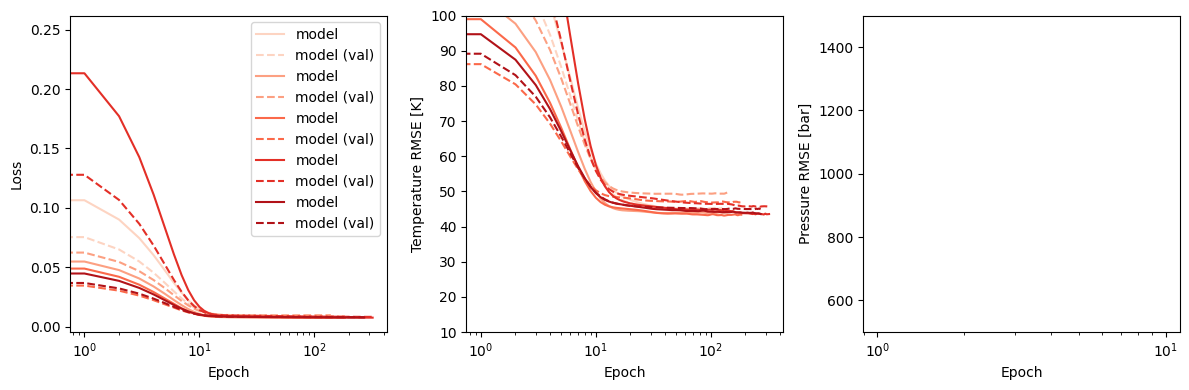

In [9]:
plot_multiple_training_curves(["AA_k_TiXMg_0.log", "AA_k_TiXMg_1.log", "AA_k_TiXMg_2.log", "AA_k_TiXMg_3.log", "AA_k_TiXMg_4.log"],
                              colors=sns.color_palette("Reds", 5), label="model", log_scale=True, ylims=[None, (10, 100), (500, 1500)], T_only=True)